In [1]:
# the code compatible with Python 2.7
import pandas as pd
import numpy as np
import scipy
import scipy.special
import scipy.stats as st
import mne
from mne import stats
from scipy.special import gamma
import matplotlib.pyplot as plt
import scipy.io as sio
from __future__ import division
import math

In [2]:
'''
    Define a fractional moment:
'''

def moment(x, k): 
    '''Compute fractional moment of order k for sample x
    INPUT:
    x:          the tested sample; should a (N x 1) or (1 x N) numpy ndarray 
    k:          moment order; k should a rational number, either integer or float
    --------
    OUTPUT:
    H:          the binary output from hypothesis testing 
    ''' 
    if type(x) != np.ndarray: 
        return 'data of a wrong type: time series x should be given as a (N x 1) or (1 x N) numpy ndarray' 
    if x.ndim != 2: 
        return 'time series x of wrong dimensions; should be (N x 1) or (1 x N) numpy ndarray' 

    N = np.max([x.shape[0], x.shape[1]])
    m = 0
    for ind in range(N):
        m += (1/N)*(complex(x[ind])**float(k))
    return [float(np.real(m)), float(np.imag(m))]



'''
    Auxiliary function 1: 
'''
def abs_moment(x, k): 
    '''Compute the mean for modules of all the samples taken to power of k for sample x
    INPUT:
    x:          the tested sample; should a (N x 1) or (1 x N) numpy ndarray 
    k:          moment order; should a rational number, either integer or float
    --------
    OUTPUT:
    H:          the binary output from hypothesis testing 
    ''' 
    
    if type(x) != np.ndarray: 
        return 'data of a wrong type: time series x should be given as a (N x 1) or (1 x N) numpy ndarray' 
    if x.ndim != 2: 
        return 'time series x of wrong dimensions; should be (N x 1) or (1 x N) numpy ndarray' 

    N = int(np.max([x.shape[0], x.shape[1]]))
    m = 0
    for ind in range(N):
        m += (1/N)*(abs(complex(x[ind])**float(k)))
    return float(m)



'''
    Auxiliary function 2: 
'''
def mn(k, s, N): 
    '''Compute the expected MEAN of all modules taken to power of k for sample x of length N
    assuming that the sample is Gaussian with mean 0 and standard distribution s:
    INPUT:
    k:          moment order; should a rational number, either integer or float
    s:          the standard dstribution in the sample; should be given as rational number, either integer or float
    N:          the sample length; should be an integer
    --------
    OUTPUT:
    mn:         the expected MEAN of all modules taken to power of k for sample x of length N
    '''     
    if type(N) != int: 
        return 'data of a wrong type: sample length should be an integer'     
    mn = (2.0**float(k/2))*(1/math.sqrt(np.pi))*gamma((1+k)/2)
    return mn



'''
    Auxiliary function 3: 
'''
def stdev(k, s, N): 
    '''Compute the STANDARD DEVIATION of all modules taken to power of k for sample x of length N
    assuming that the sample is Gaussian with mean 0 and standard distribution s:
    INPUT:
    k:          moment order; should a rational number, either integer or float
    s:          the standard dstribution in the sample; should be given as rational number, either integer or float
    N:          the sample length; should be an integer
    --------
    OUTPUT:
    sd:         the expected STANDARD DEVIATION of all modules taken to power of k for sample x of length N
    '''    
    if type(N) != int: 
        return 'data of a wrong type: sample length should be an integer'     
    sd = math.sqrt((2.0**float(k))*((1/math.sqrt(np.pi))*gamma((1+2*k)/2) - (1/np.pi)*((gamma((1+k)/2))**2)))
    sd = s*sd/math.sqrt(N)
    return sd



'''
    Auxiliary function 4: 
'''
def effect_size(p):
    '''Converting a p-value to an effect size:
    '''
    snr = - math.log10(p)
    return snr

In [3]:
'''
    Momentum test for normality:
'''

def momentum(x, ks, pthr): 
    '''Test normality of a distribution for sample x:
    INPUT:
    x:          the tested sample; it should be given as a (N x 1) or (1 x N) numpy ndarray 
    
    ks:         set of (fractional) moment orders; should be given as a list of moment orders in a float format,
                ks should NOT include the mean of the sample and variance of the sample (moments of order k = 1.0 and k = 2.0)
                e.g.: 
                ks = ks           = np.ndarray.tolist(0.1*np.arange(9)+0.1) 
                                    + np.ndarray.tolist(0.1*np.arange(9)+1.1) 
                                    + np.ndarray.tolist(0.1*np.arange(30)+2.1)
        
    pthr:       a desired confidence level; should be given as a float number between 0 and 1
    --------
    OUTPUT:
    H:          the binary output from hypothesis testing, for each moment separately 
    pvals_corr: a list of p-values after Bonferroni correction for multiple comparisons
    H0:         final output from hypothesis testing ('True' if at least one of corrected p-values is lower than pthr)
    Psubthr:    the list of corrected p-values lower than the threshold p-value
    Ksubthr:    the list of (fractional) moments returning the corrected p-values lower than threshold p-value
    ''' 
    
    if type(x) != np.ndarray: 
        return 'data of a wrong type: time series x should be given as a (N, 1) or (1, N) numpy ndarray'
    if len(x.shape) == 1:
        x = np.reshape(x, (len(x),1))
    if x.ndim != 2: 
        return 'time series x of wrong dimensions; should be (N, 1) or (1, N) numpy ndarray' 

    N                = int(np.max([x.shape[0], x.shape[1]]))
    x                = x - np.mean(x) # demean the signal
    sd_emp           = np.std(x)      # compute standard deviation of the signal
    
    pvals = np.zeros((len(ks),1))
    for ind in range(len(ks)):
        k            = ks[ind]
        m            = abs_moment(x, k)
        mean         = mn(k, sd_emp, N)
        sd           = stdev(k, sd_emp, N)
        z            = (m - mean)/sd
        pvals[ind]   = 1 - st.norm.cdf(abs(z))

    (H, pvals_corr)  = mne.stats.fdr_correction(pvals, alpha=pthr, method='indep')
    
    if len(H[np.where(H == True)]) > 0:
        H0 = True
    else:
        H0 = False
    ks               = np.reshape(np.asarray(ks), (len(ks),1)) 
    Psubthr          = pvals_corr[pvals_corr < pthr] 
    Ksubthr          = ks[pvals_corr < pthr]
    
    return [H, pvals_corr, H0, Psubthr, Ksubthr]

In [303]:
# compute and plot all fractional moments for sample drawn from a normal distribution:
# compute:
Nit          = 100
Nsamples     = 1000
# choose the set of moments for Momentum:
ks           = np.ndarray.tolist(0.1*np.arange(9)+0.1) + np.ndarray.tolist(0.1*np.arange(9)+1.1) + np.ndarray.tolist(0.1*np.arange(30)+2.1)
Nmoments     = len(ks)

# compute the fractional moments:
moments_real = np.zeros((Nmoments,Nit))
moments_imag = np.zeros((Nmoments,Nit))
abs_values   = np.zeros((Nmoments,Nit))

moments_real2 = np.zeros((Nmoments,Nit))
moments_imag2 = np.zeros((Nmoments,Nit))
abs_values2   = np.zeros((Nmoments,Nit))

for ind in range(Nit):
    x1        = np.random.normal(0,1,(Nsamples,1))
    x1        = (x1 - np.mean(x1))
    
    x2        = np.zeros((Nsamples,1))
    x2[0:int(np.floor(Nsamples/2))] = 1.0
    x2        = x2 + np.random.normal(0,1,(Nsamples,1))
    x2        = (x2 - np.mean(x2))
        
    for ind1 in range(Nmoments):
        m    = moment(x1, ks[ind1])
        moments_real[ind1,ind] = m[0]
        moments_imag[ind1,ind] = m[1]
        abs_values[ind1,ind]   = abs(complex(m[0],m[1]))
    for ind1 in range(Nmoments):
        m2    = moment(x2, ks[ind1])
        moments_real2[ind1,ind] = m2[0]
        moments_imag2[ind1,ind] = m2[1]
        abs_values2[ind1,ind]   = abs(complex(m2[0],m2[1]))

[0.00290358 0.00502849 0.00648773 0.00733126 0.00757862 0.00723513
 0.00630115 0.00477804 0.00267253 0.00321274 0.00692518 0.01108117
 0.01560707 0.02041031 0.025378   0.03037588 0.03524756 0.03981414
 0.04720566 0.0495656  0.05069546 0.05032508 0.04818148 0.04400544
 0.0375955  0.02900543 0.02048308 0.04296536 0.02647905 0.04392108
 0.0680542  0.09590556 0.12674316 0.15997019 0.19486273 0.23049842
 0.26572273 0.29912968 0.32905517 0.35358699 0.37060307 0.3778641
 0.37323173 0.35524107 0.32493035 0.2932344  0.31297483 0.50603607]


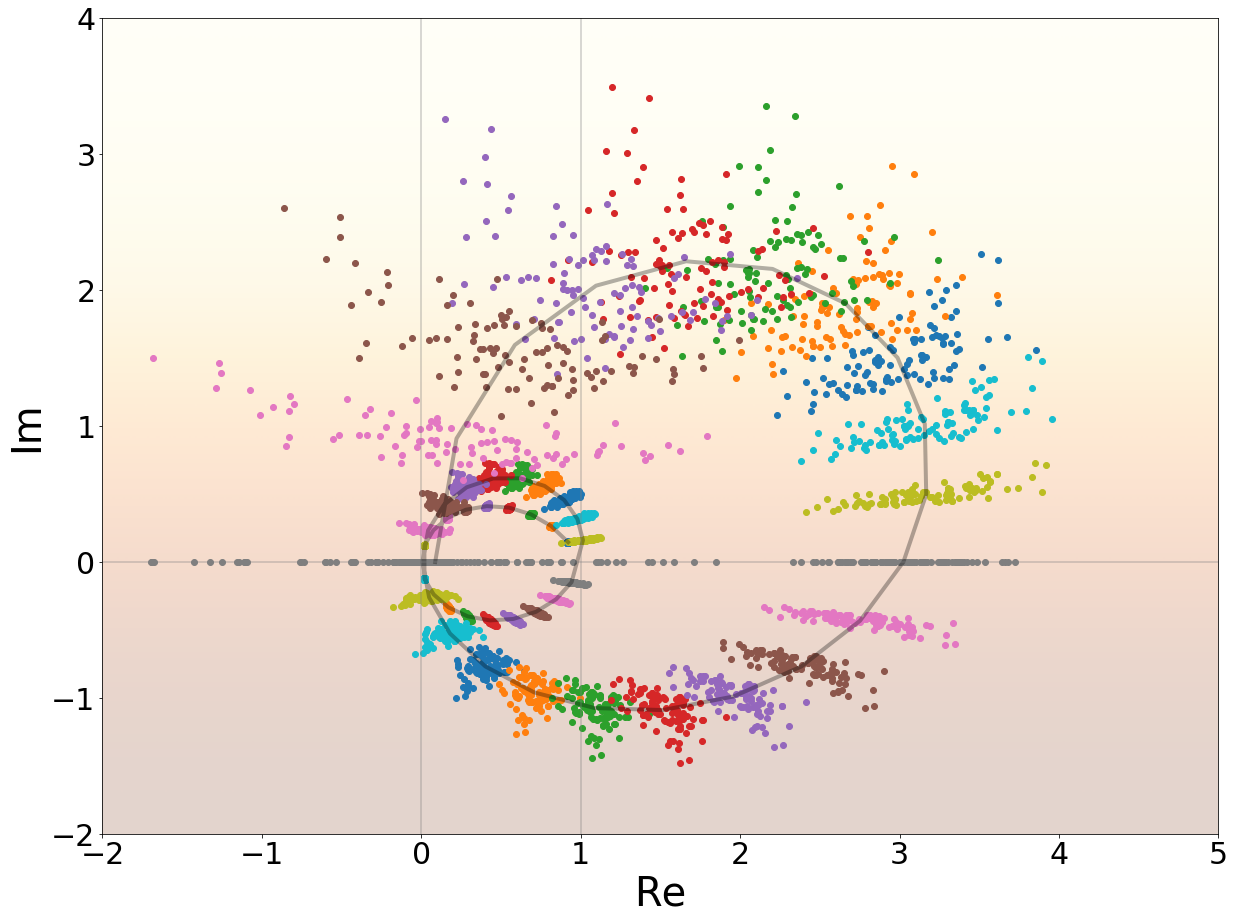

In [308]:
# plot the results:
fig = plt.figure(figsize = (20,15))
X = [[.3, .3], [.4, .4]]
ax.imshow(X, interpolation='bicubic', cmap=plt.cm.YlOrBr,
          extent=(xmin, xmax, ymin, ymax), alpha=0.2)

# add the moments:
means = np.mean(abs_values,axis=1)
stds = np.std(abs_values,axis=1)
print stds

# plot the results:


# plot the background first
xmin, xmax = xlim = -2, 5
ymin, ymax = ylim = -2, 4
ax = fig.add_subplot(111, xlim=xlim, ylim=ylim,
                     autoscale_on=False)
X = [[.3, .3], [.4, .4]]
ax.imshow(X, interpolation='bicubic', cmap=plt.cm.YlOrBr,
          extent=(xmin, xmax, ymin, ymax), alpha=0.2)

# add the moments:
means = np.mean(abs_values,axis=1)
stds = np.std(abs_values,axis=1)
plt.plot(np.mean(moments_real, axis=1), np.mean(moments_imag, axis=1), alpha=0.3, linewidth=4.0, color='k')
#plt.fill_between(means, means-stds, means+stds, color='k', alpha=0.5)

for ind1 in range(Nmoments):
    plt.scatter(moments_real[ind1,:], moments_imag[ind1,:], alpha=1.0)
     
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.xlabel('Re',fontsize=40)
plt.ylabel('Im',fontsize=40)
plt.axvline(x=0, linewidth=2.0, color='gray', alpha=0.3)
plt.axvline(x=1, linewidth=2.0, color='gray', alpha=0.3)
plt.axhline(y=0, linewidth=2.0, color='gray', alpha=0.3)
ax.set_aspect('auto')
plt.show()

[0.00290358 0.00502849 0.00648773 0.00733126 0.00757862 0.00723513
 0.00630115 0.00477804 0.00267253 0.00321274 0.00692518 0.01108117
 0.01560707 0.02041031 0.025378   0.03037588 0.03524756 0.03981414
 0.04720566 0.0495656  0.05069546 0.05032508 0.04818148 0.04400544
 0.0375955  0.02900543 0.02048308 0.04296536 0.02647905 0.04392108
 0.0680542  0.09590556 0.12674316 0.15997019 0.19486273 0.23049842
 0.26572273 0.29912968 0.32905517 0.35358699 0.37060307 0.3778641
 0.37323173 0.35524107 0.32493035 0.2932344  0.31297483 0.50603607]


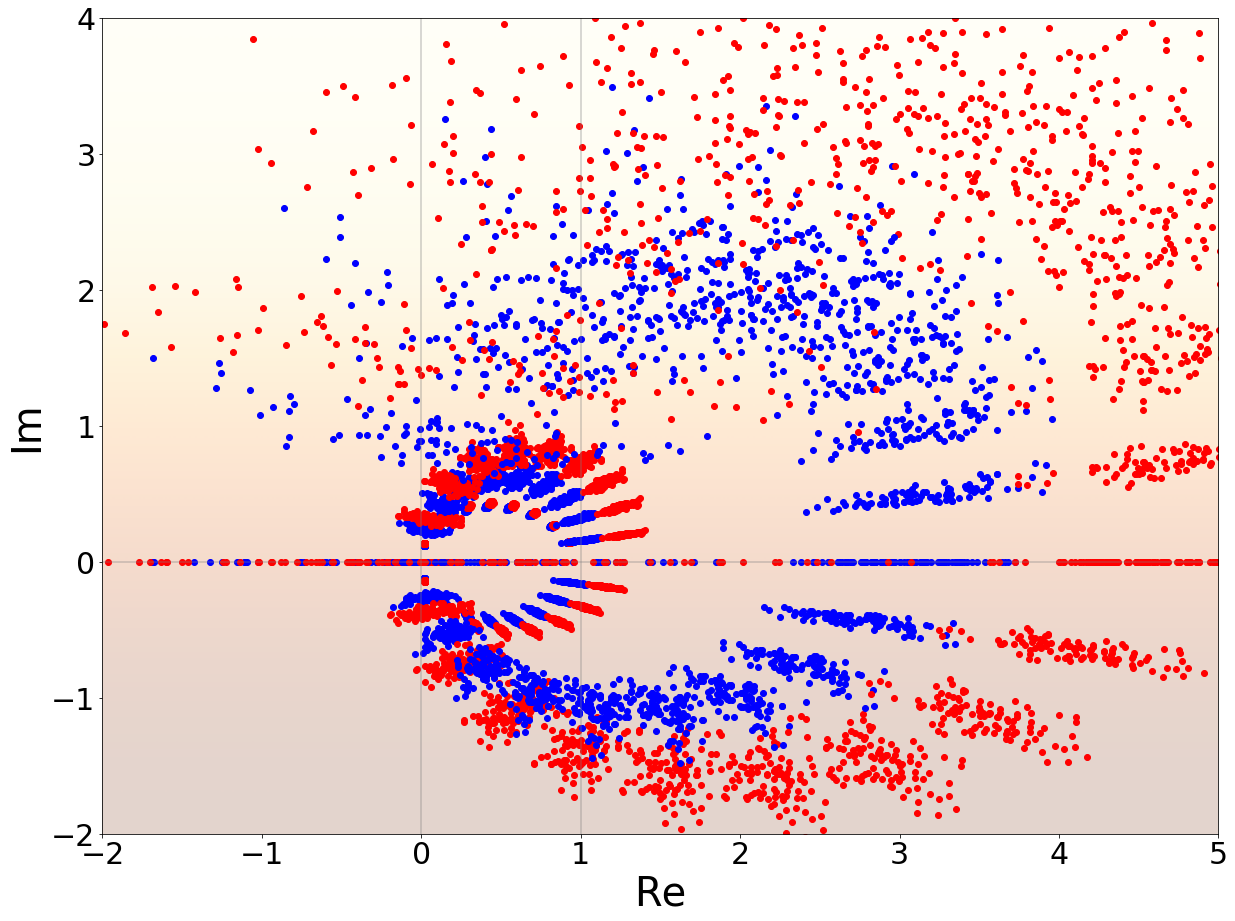

In [307]:
# plot comparison between samples drawn from normal distributin, and drawn with the signal: 
fig = plt.figure(figsize = (20,15))
X = [[.3, .3], [.4, .4]]
ax.imshow(X, interpolation='bicubic', cmap=plt.cm.YlOrBr,
          extent=(xmin, xmax, ymin, ymax), alpha=0.2)

# add the moments:
means = np.mean(abs_values,axis=1)
stds = np.std(abs_values,axis=1)
print stds

# plot the results:
# plot the background first
xmin, xmax = xlim = -2, 5
ymin, ymax = ylim = -2, 4
ax = fig.add_subplot(111, xlim=xlim, ylim=ylim,
                     autoscale_on=False)
X = [[.3, .3], [.4, .4]]
ax.imshow(X, interpolation='bicubic', cmap=plt.cm.YlOrBr,
          extent=(xmin, xmax, ymin, ymax), alpha=0.2)

# add the moments:
means = np.mean(abs_values,axis=1)
stds = np.std(abs_values,axis=1)

for ind1 in range(Nmoments):
    plt.scatter(moments_real[ind1,:], moments_imag[ind1,:], alpha=1.0, color='b')
    plt.scatter(moments_real2[ind1,:], moments_imag2[ind1,:], alpha=1.0, color='r')
     
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.xlabel('Re',fontsize=40)
plt.ylabel('Im',fontsize=40)
plt.axvline(x=0, linewidth=2.0, color='gray', alpha=0.3)
plt.axvline(x=1, linewidth=2.0, color='gray', alpha=0.3)
plt.axhline(y=0, linewidth=2.0, color='gray', alpha=0.3)
ax.set_aspect('auto')
plt.show()

In [10]:
# generate different non-Gaussian samples (and demean the data):
Nsamples     = 10000
Nit          = 100

# [a] samples from classic distributions:
# [1] normal distribution (for a sanity check):
x1           = np.random.normal(0,1,(Nsamples,Nit)) 
x1           = (x1 - np.mean(x1))

# [2] uniform distribution:
x2           = np.random.rand(Nsamples,Nit) - 0.5 
x2           = (x2 - np.mean(x2))

# [3] Chi-Square distribution:
df           = 50
x3           = np.random.chisquare(df,(Nsamples,Nit))
x3           = (x3 - np.mean(x3))

# [4] Gamma distribution:
scale, shape = 2., 2.
x4           = np.random.gamma(scale, shape,(Nsamples,Nit))
x4           = (x4 - np.mean(x4))

# [5] Geometric distribution:
x5           = np.random.geometric(p=0.35, size=(Nsamples,Nit))
x5           = (x5 - np.mean(x5))

# [6] Laplace distribution:
loc, scale   = 0., 1.
x6           = np.random.laplace(loc, scale, (Nsamples,Nit))
x6           = (x6 - np.mean(x6))

# [7] Poisson distribution:
lambd        = 5.
x7           = np.random.poisson(lambd, (Nsamples,Nit))
x7           = (x7 - np.mean(x7))

# [8] Power distribution:
shape        = 5.
x8           = np.random.power(shape, (Nsamples,Nit))
x8           = (x8 - np.mean(x8))

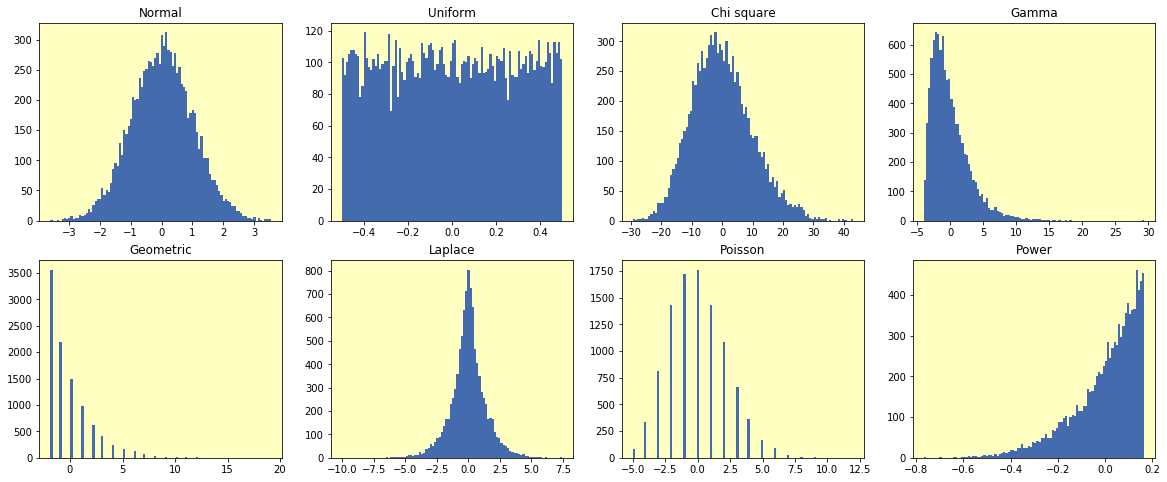

In [11]:
# plot the samples from all the classic distributions:
plt.figure(figsize=(20,8))
Nbins = int(np.floor(math.sqrt(Nsamples)))

ax1 = plt.subplot(2, 4, 1)
plt.hist(x1[:,0], Nbins, color='xkcd:french blue')
plt.title('Normal')
ax1.set_facecolor('xkcd:cream')

ax2 = plt.subplot(2, 4, 2)
plt.hist(x2[:,0], Nbins, color='xkcd:french blue')
plt.title('Uniform')
ax2.set_facecolor('xkcd:cream')

ax3 = plt.subplot(2, 4, 3)
plt.hist(x3[:,0], Nbins, color='xkcd:french blue')
plt.title('Chi square')
ax3.set_facecolor('xkcd:cream')

ax4 = plt.subplot(2, 4, 4)
plt.hist(x4[:,0], Nbins, color='xkcd:french blue')
plt.title('Gamma')
ax4.set_facecolor('xkcd:cream')

ax5 = plt.subplot(2, 4, 5)
plt.hist(x5[:,0], Nbins, color='xkcd:french blue')
plt.title('Geometric')
ax5.set_facecolor('xkcd:cream')

ax6 = plt.subplot(2, 4, 6)
plt.hist(x6[:,0], Nbins, color='xkcd:french blue')
plt.title('Laplace')
ax6.set_facecolor('xkcd:cream')

ax7 = plt.subplot(2, 4, 7)
plt.hist(x7[:,0], Nbins, color='xkcd:french blue')
plt.title('Poisson')
ax7.set_facecolor('xkcd:cream')

ax8 = plt.subplot(2, 4, 8)
plt.hist(x8[:,0], Nbins, color='xkcd:french blue')
plt.title('Power')
ax8.set_facecolor('xkcd:cream')

In [17]:
# compute the effect size for these distributions using standard methods and compare with Momentum:
print 'Nsamples: ' + str(Nsamples)
lengths = [50, 100, 250, 500, 750, 1000, 1500, 2000]
Nlengths = len(lengths)

pvals_classic_dists_SW = np.zeros((Nlengths,Nit,8)) 
pvals_classic_dists_JB = np.zeros((Nlengths,Nit,8))
pvals_classic_dists_AP = np.zeros((Nlengths,Nit,8))
pvals_classic_dists_MM = np.zeros((Nlengths,Nit,8))
snrs_classic_dists_SW = np.zeros((Nlengths,Nit,8))
snrs_classic_dists_JB = np.zeros((Nlengths,Nit,8))
snrs_classic_dists_AP = np.zeros((Nlengths,Nit,8))
snrs_classic_dists_MM = np.zeros((Nlengths,Nit,8))

for ind in range(Nlengths):
    print ind
    for ind1 in range(Nit):
        # [1] normal distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x1[0:lengths[ind], ind1])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,0] = p
        snrs_classic_dists_SW[ind,ind1,0] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x1[0:lengths[ind], ind1])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,0] = p
        snrs_classic_dists_JB[ind,ind1,0] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x1[0:lengths[ind], ind1])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,0] = p
        snrs_classic_dists_AP[ind,ind1,0] = snr

        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x1[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,0] = p
        snrs_classic_dists_MM[ind,ind1,0] = snr

        # [2] uniform distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x2[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,1] = p
        snrs_classic_dists_SW[ind,ind1,1] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x2[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,1] = p
        snrs_classic_dists_JB[ind,ind1,1] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x2[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,1] = p
        snrs_classic_dists_AP[ind,ind1,1] = snr
        
        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x2[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,1] = p
        snrs_classic_dists_MM[ind,ind1,1] = snr

        # [3] chi-square distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x3[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,2] = p
        snrs_classic_dists_SW[ind,ind1,2] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x3[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,2] = p
        snrs_classic_dists_JB[ind,ind1,2] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x3[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,2] = p
        snrs_classic_dists_AP[ind,ind1,2] = snr

        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x3[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,2] = p
        snrs_classic_dists_MM[ind,ind1,2] = snr

        # [4] Gamma distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x4[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,3] = p
        snrs_classic_dists_SW[ind,ind1,3] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x4[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,3] = p
        snrs_classic_dists_JB[ind,ind1,3] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x4[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,3] = p
        snrs_classic_dists_AP[ind,ind1,3] = snr
        
        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x4[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,3] = p
        snrs_classic_dists_MM[ind,ind1,3] = snr

        # [5] Geometric distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x5[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,4] = p
        snrs_classic_dists_SW[ind,ind1,4] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x5[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,4] = p
        snrs_classic_dists_JB[ind,ind1,4] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x5[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,4] = p
        snrs_classic_dists_AP[ind,ind1,4] = snr

        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x5[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,4] = p
        snrs_classic_dists_MM[ind,ind1,4] = snr

        # [6] Laplace distrbution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x6[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,5] = p
        snrs_classic_dists_SW[ind,ind1,5] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x6[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,5] = p
        snrs_classic_dists_JB[ind,ind1,5] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x6[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,5] = p
        snrs_classic_dists_AP[ind,ind1,5] = snr

        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x6[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,5] = p
        snrs_classic_dists_MM[ind,ind1,5] = snr

        # [7] Poisson distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x7[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,6] = p
        snrs_classic_dists_SW[ind,ind1,6] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x7[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,6] = p
        snrs_classic_dists_JB[ind,ind1,6] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x7[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,6] = p
        snrs_classic_dists_AP[ind,ind1,6] = snr

        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x7[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,6] = p
        snrs_classic_dists_MM[ind,ind1,6] = snr
        
        # [8] Power distribution:
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(x8[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_SW[ind,ind1,7] = p
        snrs_classic_dists_SW[ind,ind1,7] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(x8[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_JB[ind,ind1,7] = p
        snrs_classic_dists_JB[ind,ind1,7] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(x8[0:lengths[ind], ind1])
        p = np.min([p, 1-p])
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_AP[ind,ind1,7] = p
        snrs_classic_dists_AP[ind,ind1,7] = snr
        
        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(x8[0:lengths[ind], ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_classic_dists_MM[ind,ind1,7] = p
        snrs_classic_dists_MM[ind,ind1,7] = snr

Nsamples: 10000
0
1
2
3
4
5
6
7


In [18]:
from numpy import inf
snrs_classic_dists_SW[snrs_classic_dists_SW == inf] = 200
snrs_classic_dists_JB[snrs_classic_dists_JB == inf] = 200
snrs_classic_dists_AP[snrs_classic_dists_AP == inf] = 200
snrs_classic_dists_MM[snrs_classic_dists_MM == inf] = 200

pvals_classic_dists_SW_mean = np.mean(pvals_classic_dists_SW, axis=1)
pvals_classic_dists_JB_mean = np.mean(pvals_classic_dists_JB, axis=1)
pvals_classic_dists_AP_mean = np.mean(pvals_classic_dists_AP, axis=1)
pvals_classic_dists_MM_mean = np.mean(pvals_classic_dists_MM, axis=1)

pvals_classic_dists_SW_std = np.std(pvals_classic_dists_SW, axis=1)
pvals_classic_dists_JB_std = np.std(pvals_classic_dists_JB, axis=1)
pvals_classic_dists_AP_std = np.std(pvals_classic_dists_AP, axis=1)
pvals_classic_dists_MM_std = np.std(pvals_classic_dists_MM, axis=1)

snrs_classic_dists_SW_mean = np.mean(snrs_classic_dists_SW, axis=1)
snrs_classic_dists_JB_mean = np.mean(snrs_classic_dists_JB, axis=1)
snrs_classic_dists_AP_mean = np.mean(snrs_classic_dists_AP, axis=1)
snrs_classic_dists_MM_mean = np.mean(snrs_classic_dists_MM, axis=1)

snrs_classic_dists_SW_std = np.std(snrs_classic_dists_SW, axis=1)
snrs_classic_dists_JB_std = np.std(snrs_classic_dists_JB, axis=1)
snrs_classic_dists_AP_std = np.std(snrs_classic_dists_AP, axis=1)
snrs_classic_dists_MM_std = np.std(snrs_classic_dists_MM, axis=1)

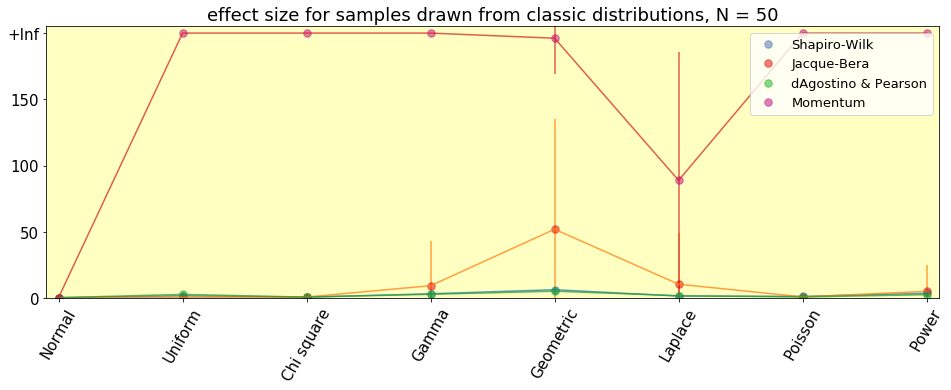

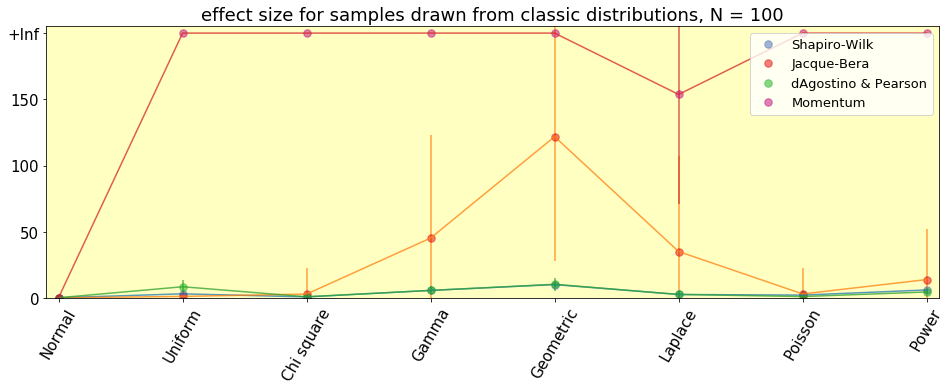

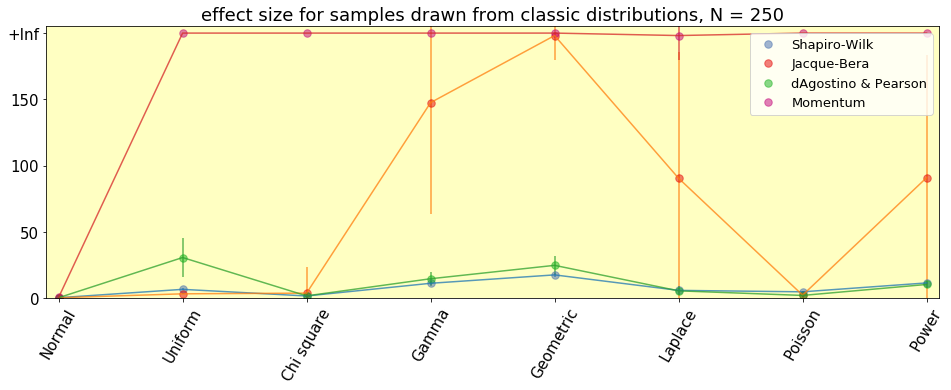

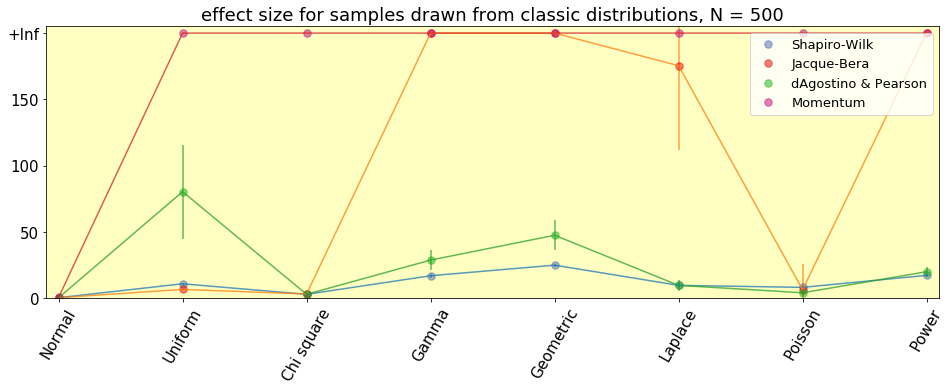

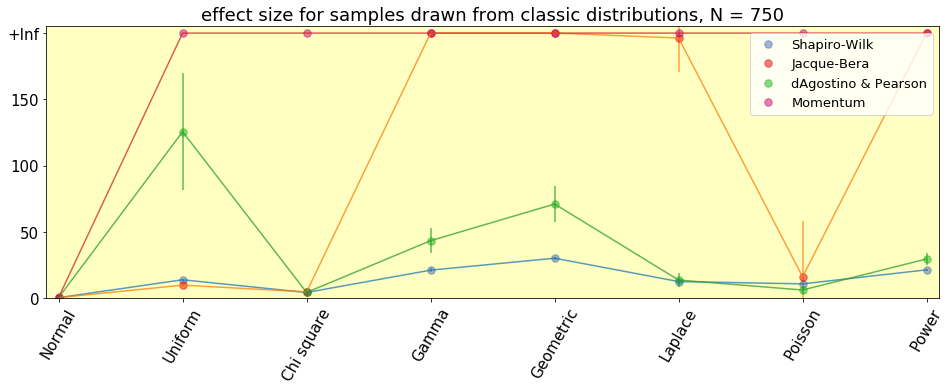

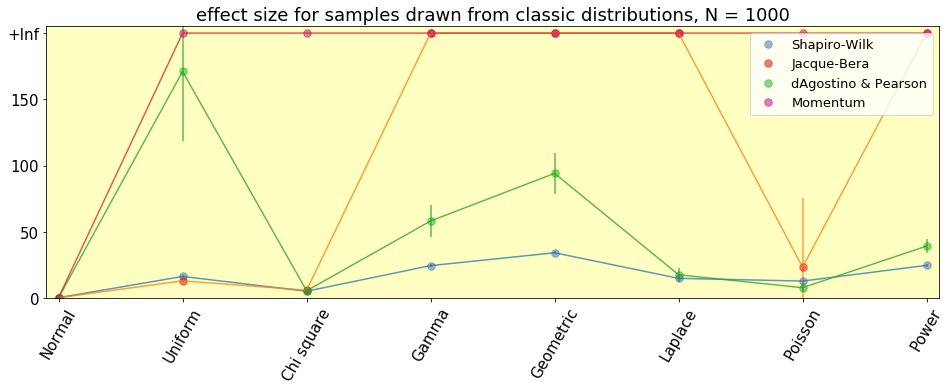

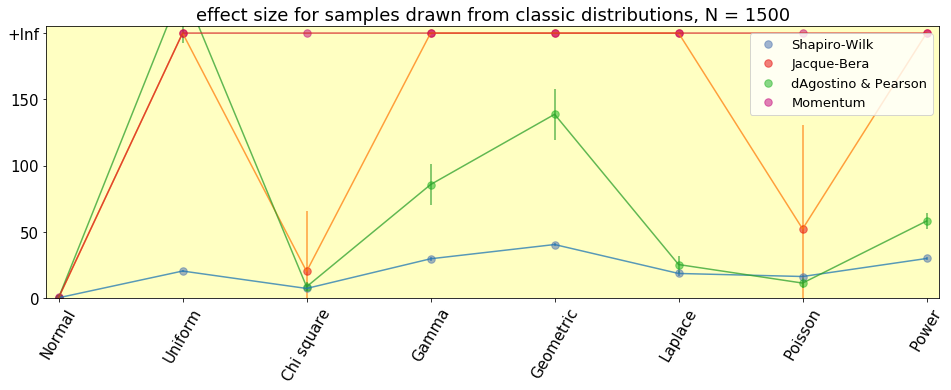

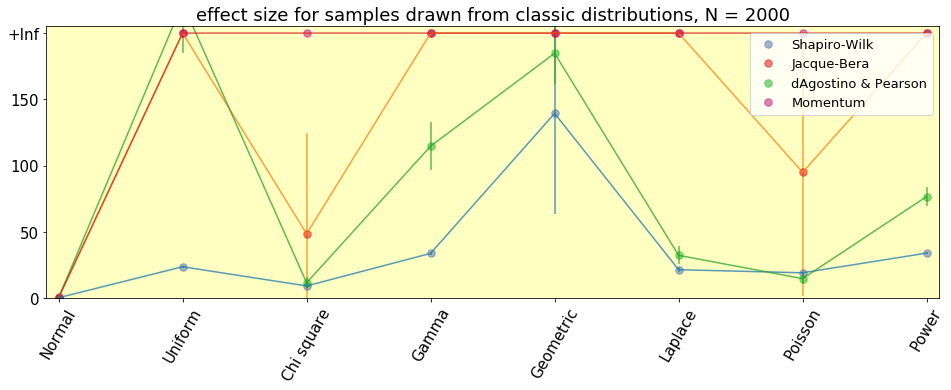

In [253]:
# plot the results for the classic distributions separately, effect sizes:
dists = ['Normal','Uniform','Chi square','Gamma','Geometric','Laplace','Poisson','Power']

for ind in range(len(lengths)):    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(snrs_classic_dists_SW_mean[ind,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
    plt.plot(snrs_classic_dists_JB_mean[ind,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
    plt.plot(snrs_classic_dists_AP_mean[ind,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
    plt.plot(snrs_classic_dists_MM_mean[ind,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
        
    plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[ind,:], yerr=snrs_classic_dists_SW_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
    plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[ind,:], yerr=snrs_classic_dists_JB_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
    plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[ind,:], yerr=snrs_classic_dists_AP_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[ind,:], yerr=snrs_classic_dists_MM_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 

    ax.set_facecolor('xkcd:cream')
    plt.legend(fontsize=13, loc='upper right')
    plt.title('effect size for samples drawn from classic distributions, N = '+str(lengths[ind]), fontsize=18)
    plt.ylim([0,205])
    plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
    plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
    plt.xlim([-0.1,len(dists)-1+0.1])
    plt.show()

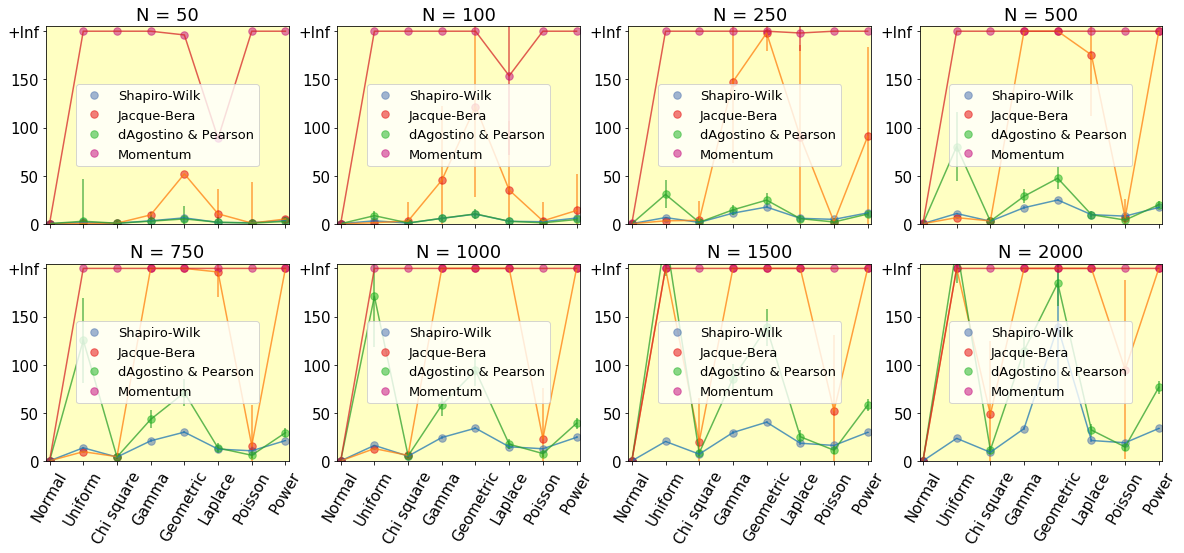

In [254]:
# plot the results for the classic distributions on one panel, effect sizes:
dists = ['Normal','Uniform','Chi square','Gamma','Geometric','Laplace','Poisson','Power']
plt.figure(figsize=(20,8))
Nbins = int(np.floor(math.sqrt(Nsamples)))

# N = 50:
ax1 = plt.subplot(2, 4, 1)
plt.plot(snrs_classic_dists_SW_mean[0,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[0,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[0,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[0,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[0,:], yerr=snrs_classic_dists_SW_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[0,:], yerr=snrs_classic_dists_JB_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[0,:], yerr=snrs_classic_dists_AP_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[0,:], yerr=snrs_classic_dists_MM_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax1.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[0]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 100:
ax2 = plt.subplot(2, 4, 2)
plt.plot(snrs_classic_dists_SW_mean[1,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[1,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[1,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[1,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[1,:], yerr=snrs_classic_dists_SW_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[1,:], yerr=snrs_classic_dists_JB_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[1,:], yerr=snrs_classic_dists_AP_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[1,:], yerr=snrs_classic_dists_MM_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax2.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[1]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 250:
ax3 = plt.subplot(2, 4, 3)
plt.plot(snrs_classic_dists_SW_mean[2,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[2,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[2,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[2,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[2,:], yerr=snrs_classic_dists_SW_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[2,:], yerr=snrs_classic_dists_JB_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[2,:], yerr=snrs_classic_dists_AP_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[2,:], yerr=snrs_classic_dists_MM_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax3.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[2]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 500:
ax4 = plt.subplot(2, 4, 4)
plt.plot(snrs_classic_dists_SW_mean[3,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[3,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[3,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[3,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[3,:], yerr=snrs_classic_dists_SW_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[3,:], yerr=snrs_classic_dists_JB_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[3,:], yerr=snrs_classic_dists_AP_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[3,:], yerr=snrs_classic_dists_MM_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax4.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[3]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 750:
ax5 = plt.subplot(2, 4, 5)
plt.plot(snrs_classic_dists_SW_mean[4,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[4,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[4,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[4,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[4,:], yerr=snrs_classic_dists_SW_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[4,:], yerr=snrs_classic_dists_JB_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[4,:], yerr=snrs_classic_dists_AP_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[4,:], yerr=snrs_classic_dists_MM_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
   
ax5.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[4]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 1000:
ax6 = plt.subplot(2, 4, 6)
plt.plot(snrs_classic_dists_SW_mean[5,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[5,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[5,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[5,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[5,:], yerr=snrs_classic_dists_SW_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[5,:], yerr=snrs_classic_dists_JB_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[5,:], yerr=snrs_classic_dists_AP_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[5,:], yerr=snrs_classic_dists_MM_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax6.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[5]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 1500:
ax7 = plt.subplot(2, 4, 7)
plt.plot(snrs_classic_dists_SW_mean[6,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[6,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[6,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[6,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[6,:], yerr=snrs_classic_dists_SW_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[6,:], yerr=snrs_classic_dists_JB_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[6,:], yerr=snrs_classic_dists_AP_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[6,:], yerr=snrs_classic_dists_MM_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax7.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[6]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# N = 2000:
ax8 = plt.subplot(2, 4, 8)
plt.plot(snrs_classic_dists_SW_mean[7,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_classic_dists_JB_mean[7,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_classic_dists_AP_mean[7,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_classic_dists_MM_mean[7,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), snrs_classic_dists_SW_mean[7,:], yerr=snrs_classic_dists_SW_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_JB_mean[7,:], yerr=snrs_classic_dists_JB_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), snrs_classic_dists_AP_mean[7,:], yerr=snrs_classic_dists_AP_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), snrs_classic_dists_MM_mean[7,:], yerr=snrs_classic_dists_MM_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    
ax8.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[7]), fontsize=18)
plt.ylim([0,205])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

plt.show()

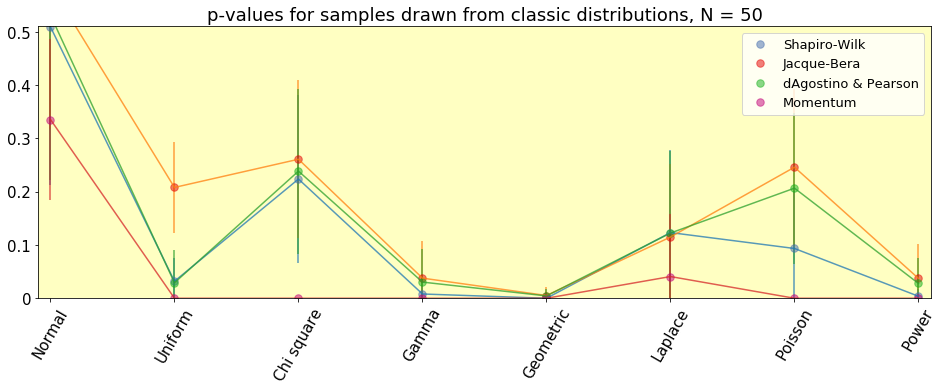

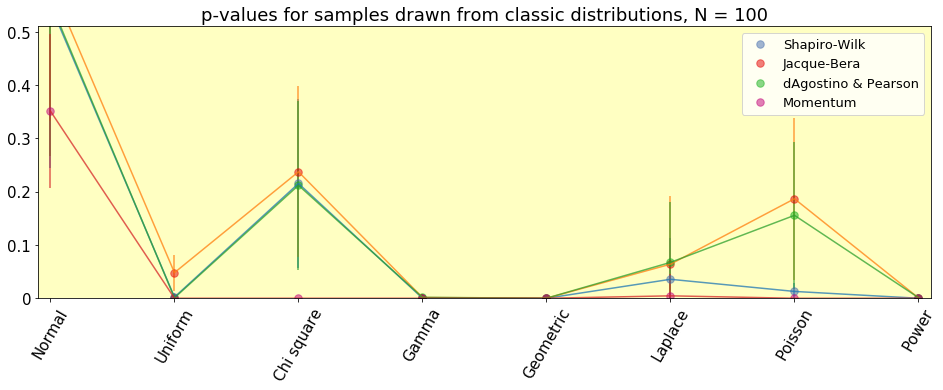

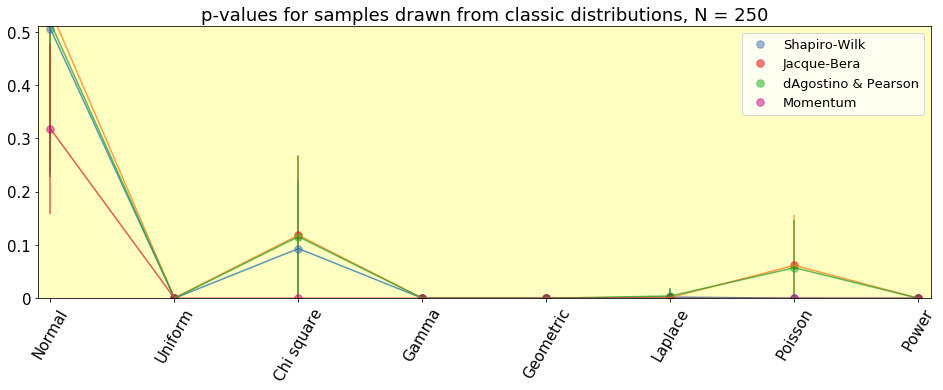

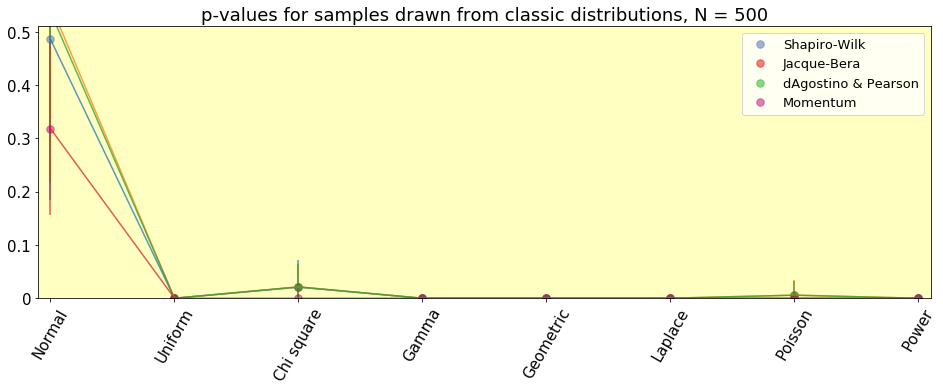

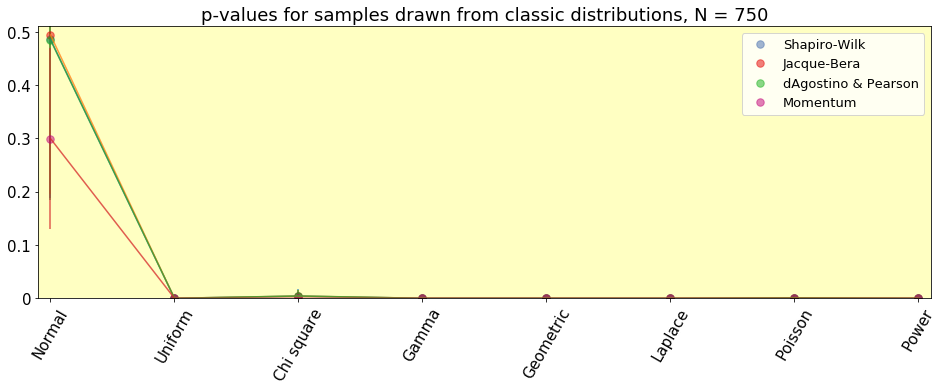

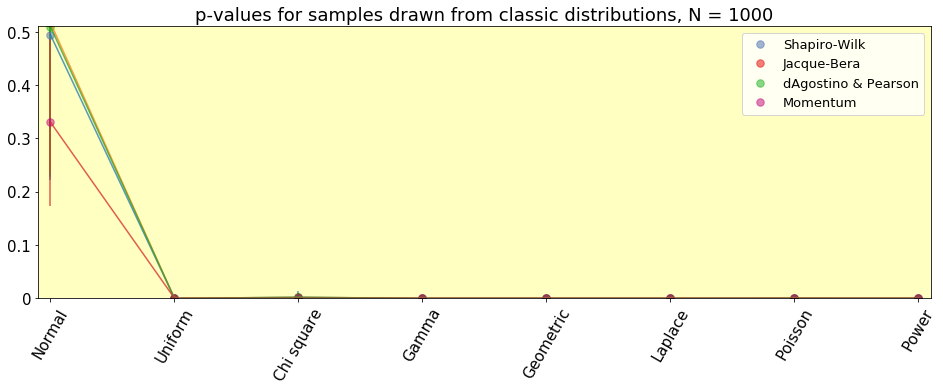

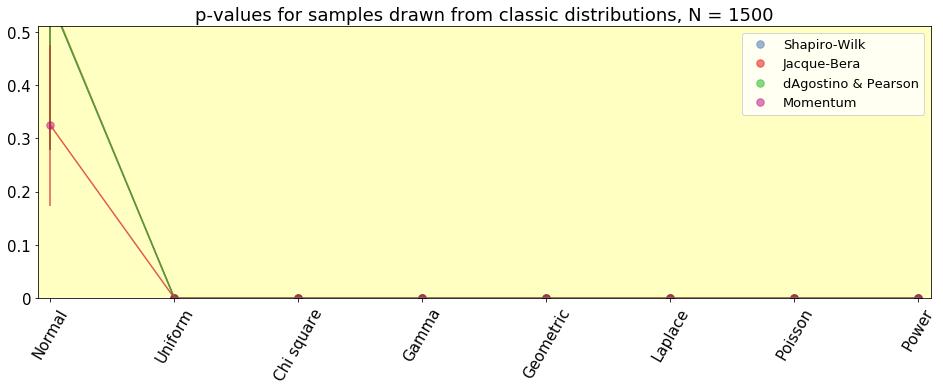

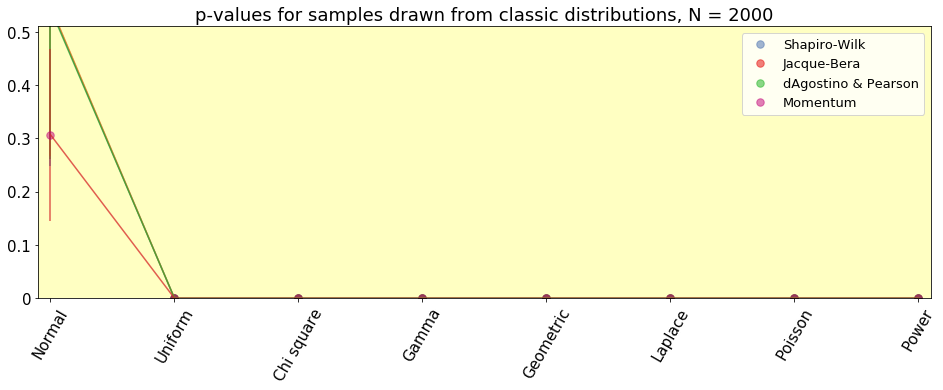

In [252]:
# plot the results for the classic distributions separately, p-values:
dists = ['Normal','Uniform','Chi square','Gamma','Geometric','Laplace','Poisson','Power']

for ind in range(len(lengths)):    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(pvals_classic_dists_SW_mean[ind,:], '. ', markersize = 15, color='xkcd:french blue', label='Shapiro-Wilk', alpha=0.5)
    plt.plot(pvals_classic_dists_JB_mean[ind,:], '. ', markersize = 15, color='xkcd:red', label='Jacque-Bera', alpha=0.5)
    plt.plot(pvals_classic_dists_AP_mean[ind,:], '. ', markersize = 15, color='xkcd:green', label='dAgostino & Pearson', alpha=0.5)
    plt.plot(pvals_classic_dists_MM_mean[ind,:], '. ', markersize = 15, color='xkcd:magenta', label='Momentum', alpha=0.5)
    
    plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[ind,:], yerr=pvals_classic_dists_SW_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
    plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[ind,:], yerr=pvals_classic_dists_JB_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
    plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[ind,:], yerr=pvals_classic_dists_AP_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
    plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[ind,:], yerr=pvals_classic_dists_MM_std[ind,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
    ax.set_facecolor('xkcd:cream')
    plt.legend(fontsize=13, loc='upper right')
    plt.title('p-values for samples drawn from classic distributions, N = '+str(lengths[ind]), fontsize=18)
    plt.ylim([0,0.51])
    plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
    plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
    plt.xlim([-0.1,len(dists)-1+0.1])
    plt.show()

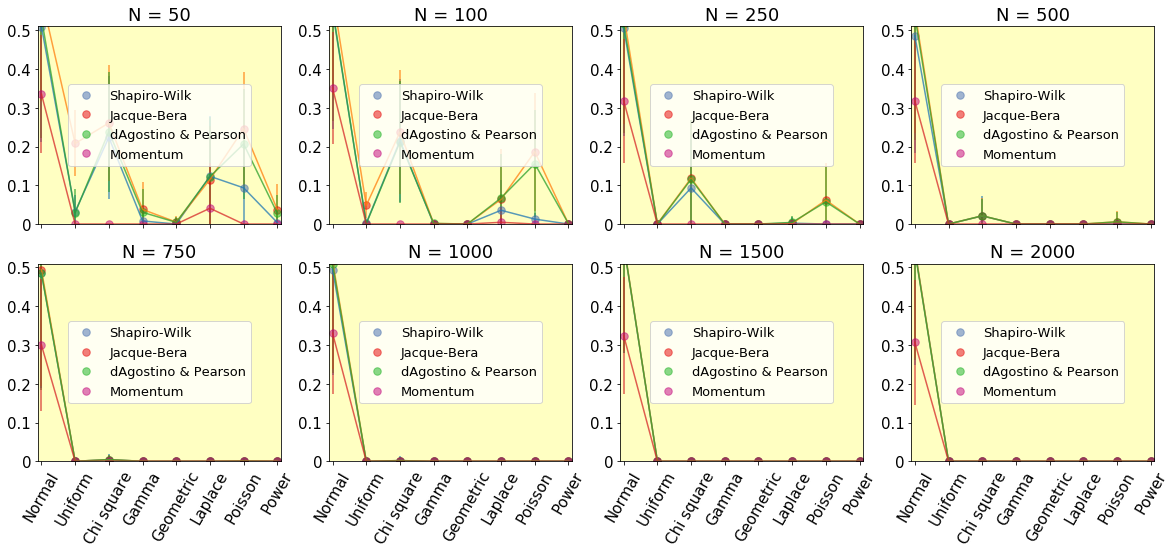

In [255]:
# plot the results for the classic distributionson one panel, p-values:
dists = ['Normal','Uniform','Chi square','Gamma','Geometric','Laplace','Poisson','Power']
plt.figure(figsize=(20,8))
Nbins = int(np.floor(math.sqrt(Nsamples)))

# [1] Normal distribution:
ax1 = plt.subplot(2, 4, 1)
plt.plot(pvals_classic_dists_SW_mean[0,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[0,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[0,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[0,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[0,:], yerr=pvals_classic_dists_SW_std[0,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[0,:], yerr=pvals_classic_dists_JB_std[0,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[0,:], yerr=pvals_classic_dists_AP_std[0,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[0,:], yerr=pvals_classic_dists_MM_std[0,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax1.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[0]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [2] Uniform distribution:
ax2 = plt.subplot(2, 4, 2)
plt.plot(pvals_classic_dists_SW_mean[1,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[1,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[1,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[1,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[1,:], yerr=pvals_classic_dists_SW_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[1,:], yerr=pvals_classic_dists_JB_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[1,:], yerr=pvals_classic_dists_AP_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[1,:], yerr=pvals_classic_dists_MM_std[1,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax2.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[1]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [3] Chi square distribution:
ax3 = plt.subplot(2, 4, 3)
plt.plot(pvals_classic_dists_SW_mean[2,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[2,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[2,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[2,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[2,:], yerr=pvals_classic_dists_SW_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[2,:], yerr=pvals_classic_dists_JB_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[2,:], yerr=pvals_classic_dists_AP_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[2,:], yerr=pvals_classic_dists_MM_std[2,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax3.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[2]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [4] Gamma distribution:
ax4 = plt.subplot(2, 4, 4)
plt.plot(pvals_classic_dists_SW_mean[3,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[3,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[3,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[3,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[3,:], yerr=pvals_classic_dists_SW_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[3,:], yerr=pvals_classic_dists_JB_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[3,:], yerr=pvals_classic_dists_AP_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[3,:], yerr=pvals_classic_dists_MM_std[3,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax4.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[3]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), [], rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [5] Geometric distribution:
ax5 = plt.subplot(2, 4, 5)
plt.plot(pvals_classic_dists_SW_mean[4,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[4,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[4,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[4,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[4,:], yerr=pvals_classic_dists_SW_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[4,:], yerr=pvals_classic_dists_JB_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[4,:], yerr=pvals_classic_dists_AP_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[4,:], yerr=pvals_classic_dists_MM_std[4,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax5.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[4]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [6] Laplace distribution:
ax6 = plt.subplot(2, 4, 6)
plt.plot(pvals_classic_dists_SW_mean[5,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[5,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[5,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[5,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[5,:], yerr=pvals_classic_dists_SW_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[5,:], yerr=pvals_classic_dists_JB_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[5,:], yerr=pvals_classic_dists_AP_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[5,:], yerr=pvals_classic_dists_MM_std[5,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax6.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[5]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [7] Poisson distribution:
ax7 = plt.subplot(2, 4, 7)
plt.plot(pvals_classic_dists_SW_mean[6,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[6,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[6,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[6,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[6,:], yerr=pvals_classic_dists_SW_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[6,:], yerr=pvals_classic_dists_JB_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[6,:], yerr=pvals_classic_dists_AP_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[6,:], yerr=pvals_classic_dists_MM_std[6,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
     
ax7.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[6]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

# [8] Power distribution:
ax8 = plt.subplot(2, 4, 8)
plt.plot(pvals_classic_dists_SW_mean[7,:], '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_classic_dists_JB_mean[7,:], '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_classic_dists_AP_mean[7,:], '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_classic_dists_MM_mean[7,:], '. ', markersize = 15, color='xkcd:magenta', linewidth=4.0, label='Momentum', alpha=0.5)
    
plt.errorbar(np.arange(8), pvals_classic_dists_SW_mean[7,:], yerr=pvals_classic_dists_SW_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:french blue', linewidth=4.0, label='Shapiro-Wilk', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_JB_mean[7,:], yerr=pvals_classic_dists_JB_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:red', linewidth=4.0, label='Jacque-Bera', alpha=0.5)
plt.errorbar(np.arange(8), pvals_classic_dists_AP_mean[7,:], yerr=pvals_classic_dists_AP_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
plt.errorbar(np.arange(8), pvals_classic_dists_MM_mean[7,:], yerr=pvals_classic_dists_MM_std[7,:], alpha=0.75)#, '. ', markersize = 15, color='xkcd:green', linewidth=4.0, label='DAgostino & Pearson', alpha=0.5) 
 
ax8.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='center')
plt.title('N = ' + str(lengths[7]), fontsize=18)
plt.ylim([0,0.51])
plt.xticks(np.arange(8), dists, rotation=60, fontsize=15)
plt.yticks(0.1*np.arange(6), ['0','0.1','0.2','0.3','0.4','0.5'], fontsize=15)
plt.xlim([-0.1,len(dists)-1+0.1])

plt.show()

In [182]:
# produce exemplary biological signals:
snr = 1.0

# [a] make an exemplary mixture of a flat binary signal and white noise:
y1                                      = np.zeros((Nsamples,Nsnrs))
for ind in range(Nsnrs):
    signal                              = np.zeros((Nsamples,1))
    signal[0:int(np.floor(Nsamples/2))] = snr
    signal                              = signal + np.asarray(np.random.normal(0,1,(Nsamples,1)))
    signal                              = np.reshape(signal, (Nsamples,))
    y1[:,ind]                           = signal

In [183]:
# [b] make an exemplary mixture of sinusoidal signal and white noise:
Fs                              = Nsamples
f                               = 5
y2                              = np.zeros((Nsamples,Nsnrs))

for ind in range(Nsnrs):
    signal                      = np.zeros((Nsamples,1))
    signal                      = snr*np.sin(2 * np.pi * f * np.arange(Nsamples) / Fs)
    signal                      = np.transpose(signal + np.random.normal(0,1,(1,Nsamples)))
    signal                      = np.reshape(signal, (Nsamples,))
    y2[:,ind]                   = signal

(-5, 5)

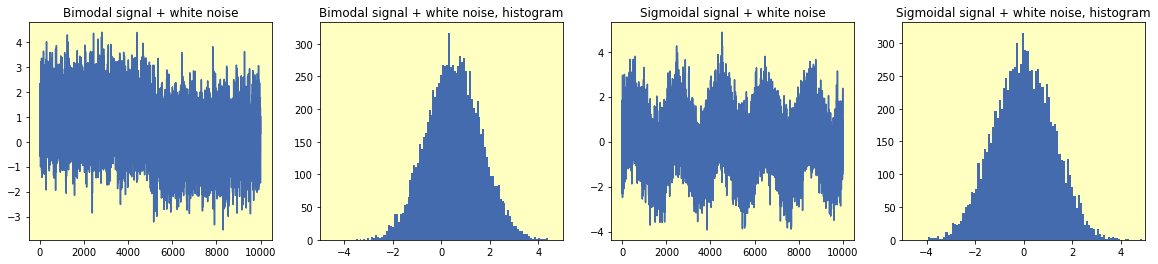

In [184]:
# plot exemplary biological signals:
plt.figure(figsize=(20,4))
Nbins = int(np.floor(math.sqrt(Nsamples)))

ax1 = plt.subplot(1, 4, 1)
plt.plot(y1[:,7], color='xkcd:french blue')
plt.title('Bimodal signal + white noise')
ax1.set_facecolor('xkcd:cream')

ax2 = plt.subplot(1, 4, 2)
plt.hist(y1[:,7], Nbins, color='xkcd:french blue')
plt.title('Bimodal signal + white noise, histogram')
ax2.set_facecolor('xkcd:cream')
plt.xlim([-5,5])

ax3 = plt.subplot(1, 4, 3)
plt.plot(y2[:,7], color='xkcd:french blue')
plt.title('Sigmoidal signal + white noise')
ax3.set_facecolor('xkcd:cream')

ax4 = plt.subplot(1, 4, 4)
plt.hist(y2[:,7], Nbins, color='xkcd:french blue')
plt.title('Sigmoidal signal + white noise, histogram')
ax4.set_facecolor('xkcd:cream')
plt.xlim([-5,5])

In [173]:
# produce a large set of biological signals for further testing:
Nit                                         = 100
Nsamples                                    = 10000
snrs                                        = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 
                                               0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 
                                               1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]
Nsnrs                                       = len(snrs)


# [a] a mixture of a flat binary signal and white noise:
y1                                          = np.zeros((Nsamples,Nsnrs,Ntrials))
for ind in range(Nsnrs):
    for ind1 in range(Nit):
        signal                              = np.zeros((Nsamples,1))
        signal[0:int(np.floor(Nsamples/2))] = snrs[ind]
        signal                              = signal + np.asarray(np.random.normal(0,1,(Nsamples,1)))
        signal = (signal - np.mean(signal))
        signal                              = np.reshape(signal, (Nsamples,))
        y1[:,ind,ind1]                      = signal

# [b] a mixture of sinusoidal signal and white noise:
Fs                                          = Nsamples
f                                           = 5
y2                                          = np.zeros((Nsamples,Nsnrs,Ntrials))

for ind in range(Nsnrs):
    for ind1 in range(Nit):
        signal                              = np.zeros((Nsamples,1))
        signal                              = snrs[ind]*np.sin(2 * np.pi * f * np.arange(Nsamples) / Fs)
        signal                              = np.transpose(signal + np.random.normal(0,1,(1,Nsamples)))
        signal                              = (signal - np.mean(signal))
        signal                              = np.reshape(signal, (Nsamples,))
        y2[:,ind,ind1]                      = signal

In [175]:
# testing standard methods on the biological signals and compare them with Momentum:
# compute SNR for these distributions with standard methods:
pvals_biological_SW = np.zeros((Nsnrs,2,Ntrials)) # 2 as we have binary signals and oscillatory signal
pvals_biological_JB = np.zeros((Nsnrs,2,Ntrials))
pvals_biological_AP = np.zeros((Nsnrs,2,Ntrials))
pvals_biological_MM = np.zeros((Nsnrs,2,Ntrials))
snrs_biological_SW = np.zeros((Nsnrs,2,Ntrials))
snrs_biological_JB = np.zeros((Nsnrs,2,Ntrials))
snrs_biological_AP = np.zeros((Nsnrs,2,Ntrials))
snrs_biological_MM = np.zeros((Nsnrs,2,Ntrials))

print("\n binary signals:")
# binary signals:
for ind in range(Nsnrs):
    print ind
    for ind1 in range(Ntrials):
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(y1[:,ind,ind1])
        if p < 1e-20:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_SW[ind,0,ind1] = p
        snrs_biological_SW[ind,0,ind1] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(y1[:,ind,ind1])
        if p < 1e-20:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_JB[ind,0,ind1] = p
        snrs_biological_JB[ind,0,ind1] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(y1[:,ind,ind1])
        if p < 1e-20:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_AP[ind,0,ind1] = p
        snrs_biological_AP[ind,0,ind1] = snr
        
        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(y1[:,ind,ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_MM[ind,0,ind1] = p
        snrs_biological_MM[ind,0,ind1] = snr

print("\n oscillatory signals:")
# binary signals:
for ind in range(Nsnrs):
    print ind
    for ind1 in range(Ntrials):
        # Shapiro-Wilk:
        (stat, p) = scipy.stats.shapiro(y2[:,ind,ind1])
        if p < 1e-20:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_SW[ind,1,ind1] = p
        snrs_biological_SW[ind,1,ind1] = snr

        # Jacque-Bera:
        (stat, p) = scipy.stats.jarque_bera(y2[:,ind,ind1])
        if p < 1e-20:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_JB[ind,1,ind1] = p
        snrs_biological_JB[ind,1,ind1] = snr

        # D'Agostino & Pearson:
        (stat, p) = scipy.stats.normaltest(y2[:,ind,ind1])
        if p < 1e-20:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_AP[ind,1,ind1] = p
        snrs_biological_AP[ind,1,ind1] = snr
        
        # Momentum:
        [H, pvals_corr, H0, Psubthr, Ksubthr] = momentum(y2[:,ind,ind1], ks, 0.05)
        p = np.min(pvals_corr)
        if p == 0:
            snr = float('inf')
        else:
            snr = effect_size(p)
        pvals_biological_MM[ind,1,ind1] = p
        snrs_biological_MM[ind,1,ind1] = snr


 binary signals:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30

 oscillatory signals:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [177]:
from numpy import inf
snrs_biological_SW[snrs_biological_SW == inf] = 200
snrs_biological_JB[snrs_biological_JB == inf] = 200
snrs_biological_AP[snrs_biological_AP == inf] = 200
snrs_biological_MM[snrs_biological_MM == inf] = 200

pvals_biological_SW_mean = np.mean(pvals_biological_SW, axis=2)
pvals_biological_JB_mean = np.mean(pvals_biological_JB, axis=2)
pvals_biological_AP_mean = np.mean(pvals_biological_AP, axis=2)
pvals_biological_MM_mean = np.mean(pvals_biological_MM, axis=2)

snrs_biological_SW_mean = np.mean(snrs_biological_SW, axis=2)
snrs_biological_JB_mean = np.mean(snrs_biological_JB, axis=2)
snrs_biological_AP_mean = np.mean(snrs_biological_AP, axis=2)
snrs_biological_MM_mean = np.mean(snrs_biological_MM, axis=2)

pvals_biological_SW_std = np.std(pvals_biological_SW, axis=2)
pvals_biological_JB_std = np.std(pvals_biological_JB, axis=2)
pvals_biological_AP_std = np.std(pvals_biological_AP, axis=2)
pvals_biological_MM_std = np.std(pvals_biological_MM, axis=2)

snrs_biological_SW_std = np.std(snrs_biological_SW, axis=2)
snrs_biological_JB_std = np.std(snrs_biological_JB, axis=2)
snrs_biological_AP_std = np.std(snrs_biological_AP, axis=2)
snrs_biological_MM_std = np.std(snrs_biological_MM, axis=2)

Text(0,0.5,'effect size')

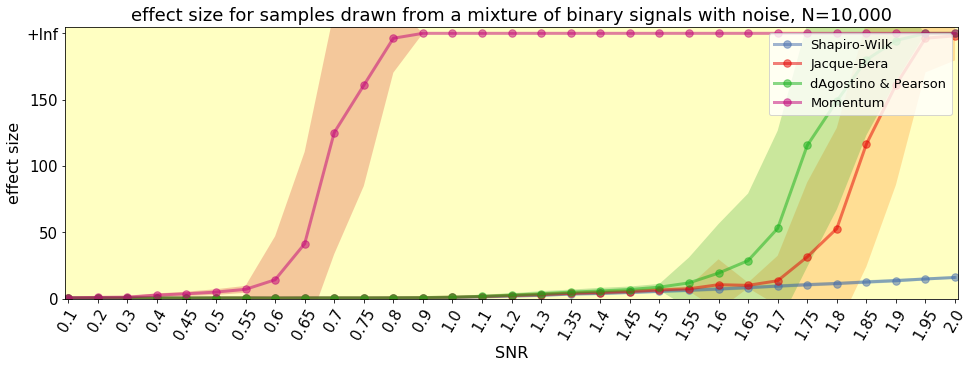

In [178]:
# plot the results for the biological signals, binary signal, effect sizes:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(snrs_biological_SW_mean[:,0], '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_biological_JB_mean[:,0], '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_biological_AP_mean[:,0], '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_biological_MM_mean[:,0], '.-', markersize = 15, color='xkcd:magenta', linewidth=3.0, label='Momentum', alpha=0.5)

plt.fill_between(np.arange(Nsnrs), snrs_biological_SW_mean[:,0]-snrs_biological_SW_std[:,0], snrs_biological_SW_mean[:,0]+snrs_biological_SW_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), snrs_biological_JB_mean[:,0]-snrs_biological_JB_std[:,0], snrs_biological_JB_mean[:,0]+snrs_biological_JB_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), snrs_biological_AP_mean[:,0]-snrs_biological_AP_std[:,0], snrs_biological_AP_mean[:,0]+snrs_biological_AP_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), snrs_biological_MM_mean[:,0]-snrs_biological_MM_std[:,0], snrs_biological_MM_mean[:,0]+snrs_biological_MM_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)

ax.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='upper right')
plt.title('effect size for samples drawn from a mixture of binary signals with noise, N=10,000', fontsize=18)
plt.ylim([0,205])
plt.xlim([-0.1, Nsnrs-1+0.1])
plt.xticks(np.arange(Nsnrs), snrs, rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('effect size', fontsize=16)

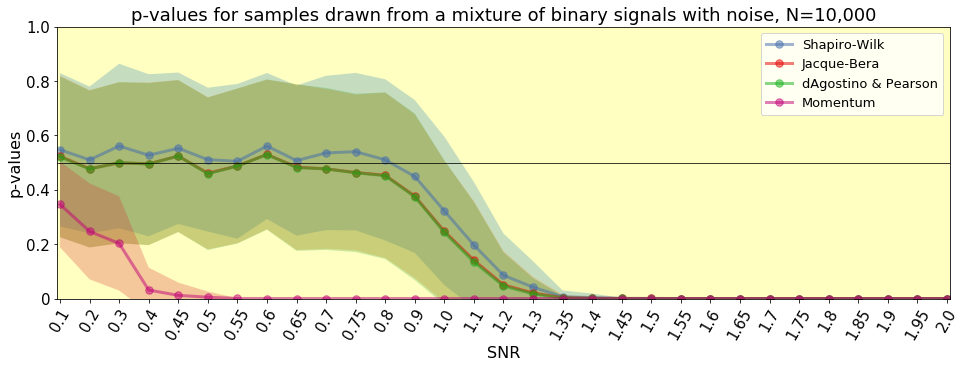

In [179]:
# plot the results for the biological signals, binary signal, p-values:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(pvals_biological_SW_mean[:,0], '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_biological_JB_mean[:,0], '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_biological_AP_mean[:,0], '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_biological_MM_mean[:,0], '.-', markersize = 15, color='xkcd:magenta', linewidth=3.0, label='Momentum', alpha=0.5)

plt.fill_between(np.arange(Nsnrs), pvals_biological_SW_mean[:,0]-pvals_biological_SW_std[:,0], pvals_biological_SW_mean[:,0]+pvals_biological_SW_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), pvals_biological_JB_mean[:,0]-pvals_biological_JB_std[:,0], pvals_biological_JB_mean[:,0]+pvals_biological_JB_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), pvals_biological_AP_mean[:,0]-pvals_biological_AP_std[:,0], pvals_biological_AP_mean[:,0]+pvals_biological_AP_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), pvals_biological_MM_mean[:,0]-pvals_biological_MM_std[:,0], pvals_biological_MM_mean[:,0]+pvals_biological_MM_std[:,0], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)

ax.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='upper right')
plt.title('p-values for samples drawn from a mixture of binary signals with noise, N=10,000', fontsize=18)
plt.ylim([0,0.5])
plt.xlim([-0.1, Nsnrs-1+0.1])
plt.xticks(np.arange(Nsnrs), snrs, rotation=60, fontsize=15)
plt.yticks(0.2*np.arange(6), ['0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('p-values', fontsize=16)
plt.axhline(y=0.5, linewidth=0.75, color='k')

Text(0,0.5,'effect size')

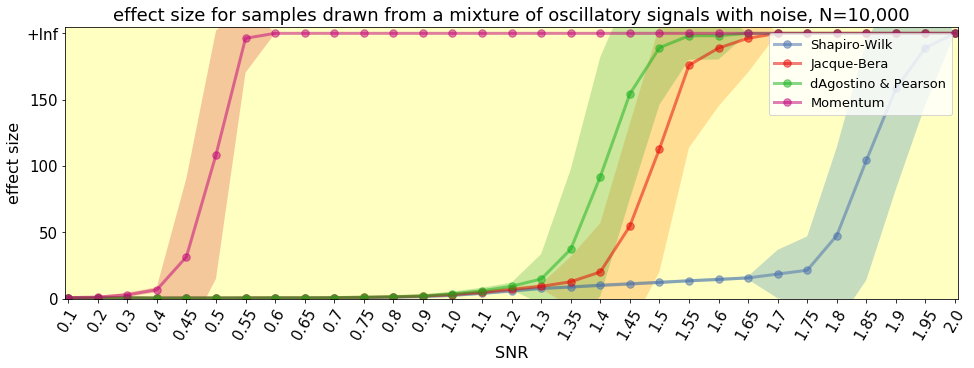

In [180]:
# plot the results for the biological signals, oscillatory signal, p-values:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(snrs_biological_SW_mean[:,1], '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(snrs_biological_JB_mean[:,1], '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.plot(snrs_biological_AP_mean[:,1], '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(snrs_biological_MM_mean[:,1], '.-', markersize = 15, color='xkcd:magenta', linewidth=3.0, label='Momentum', alpha=0.5)

plt.fill_between(np.arange(Nsnrs), snrs_biological_SW_mean[:,1]-snrs_biological_SW_std[:,1], snrs_biological_SW_mean[:,1]+snrs_biological_SW_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), snrs_biological_JB_mean[:,1]-snrs_biological_JB_std[:,1], snrs_biological_JB_mean[:,1]+snrs_biological_JB_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), snrs_biological_AP_mean[:,1]-snrs_biological_AP_std[:,1], snrs_biological_AP_mean[:,1]+snrs_biological_AP_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), snrs_biological_MM_mean[:,1]-snrs_biological_MM_std[:,1], snrs_biological_MM_mean[:,1]+snrs_biological_MM_std[:,1], alpha=0.25)#, '

ax.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='upper right')
plt.title('effect size for samples drawn from a mixture of oscillatory signals with noise, N=10,000', fontsize=18)
plt.ylim([0,205])
plt.xlim([-0.1, Nsnrs-1+0.1])
plt.xticks(np.arange(Nsnrs), snrs, rotation=60, fontsize=15)
plt.yticks(50*np.arange(5), ['0','50','100','150','+Inf'], fontsize=15)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('effect size', fontsize=16)

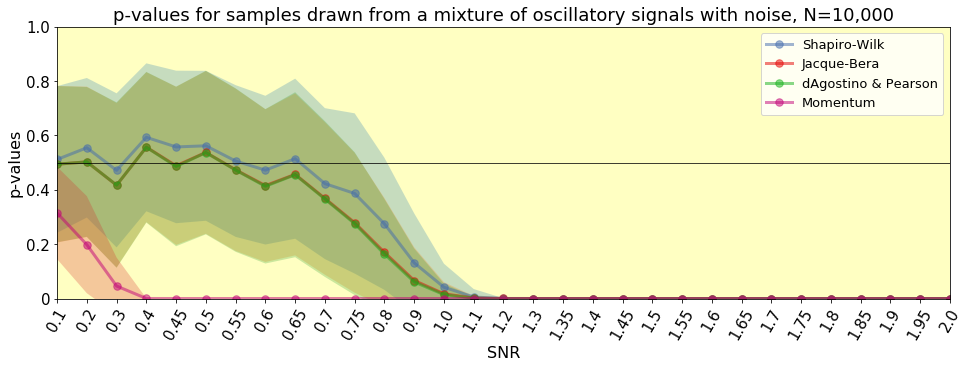

In [181]:
# plot the results for the biological signals, oscillatory signal, p-values:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(pvals_biological_SW_mean[:,1], '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.plot(pvals_biological_JB_mean[:,1], '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.plot(pvals_biological_AP_mean[:,1], '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='dAgostino & Pearson', alpha=0.5)
plt.plot(pvals_biological_MM_mean[:,1], '.-', markersize = 15, color='xkcd:magenta', linewidth=3.0, label='Momentum', alpha=0.5)

plt.fill_between(np.arange(Nsnrs), pvals_biological_SW_mean[:,1]-pvals_biological_SW_std[:,1], pvals_biological_SW_mean[:,1]+pvals_biological_SW_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:french blue', linewidth=3.0, label='Shapiro-Wilk', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), pvals_biological_JB_mean[:,1]-pvals_biological_JB_std[:,1], pvals_biological_JB_mean[:,1]+pvals_biological_JB_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:red', linewidth=3.0, label='Jacque-Bera', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), pvals_biological_AP_mean[:,1]-pvals_biological_AP_std[:,1], pvals_biological_AP_mean[:,1]+pvals_biological_AP_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)
plt.fill_between(np.arange(Nsnrs), pvals_biological_MM_mean[:,1]-pvals_biological_MM_std[:,1], pvals_biological_MM_mean[:,1]+pvals_biological_MM_std[:,1], alpha=0.25)#, '.-', markersize = 15, color='xkcd:green', linewidth=3.0, label='DAgostino & Pearson', alpha=0.5)


ax.set_facecolor('xkcd:cream')
plt.legend(fontsize=13, loc='upper right')
plt.title('p-values for samples drawn from a mixture of oscillatory signals with noise, N=10,000', fontsize=18)
plt.ylim([0,0.5])
plt.xlim([0, snrs[-1]])
plt.xticks(np.arange(Nsnrs), snrs, rotation=60, fontsize=15)
#plt.xticks(snrs, snrs, rotation=60, fontsize=15)
plt.yticks(0.2*np.arange(6), ['0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('p-values', fontsize=16)
plt.axhline(y=0.5, linewidth=0.75, color='k')